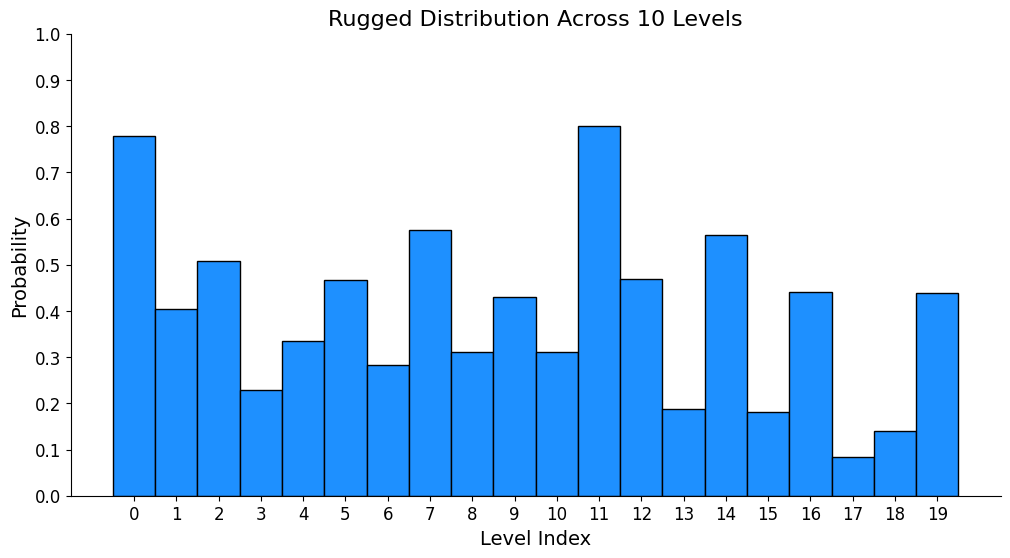

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the random seed for reproducibility
np.random.seed(42)

# Generate a single random distribution for 10 different levels
num_levels = 20
levels = np.arange(num_levels)
distribution = np.random.normal(loc=0.5, scale=0.5, size=num_levels)

# Clip the values to ensure they are within [0, 1]
distribution = np.clip(distribution, 0, 1)

# Normalize the distribution to ensure the probabilities sum to 1
distribution /= distribution.sum()

# Add some noise to create a rugged look
rugged_distribution = distribution + np.random.normal(0.4, 0.2, size=num_levels)
rugged_distribution = np.clip(rugged_distribution, 0, 1)  # Ensure values stay within [0, 1]

# Create a figure with a white background
plt.figure(figsize=(12, 6), facecolor='white')

# Create a simple bar chart with no space between bars
bars = plt.bar(levels, rugged_distribution, width=1.0, color='dodgerblue', edgecolor='black')

# Customize the plot
plt.title('Rugged Distribution Across 10 Levels', fontsize=16)
plt.xlabel('Level Index', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.ylim(0, 1)  # Set y-axis to range [0, 1]
plt.xticks(levels, fontsize=12)
plt.yticks(np.linspace(0, 1, 11), fontsize=12)
sns.despine()  # Remove the top and right spines

# Remove grid lines
plt.grid(False)

# Display the plot
plt.show()

Test Verti-Selector

In [2]:
import gymnasium as gym
from stable_baselines3 import PPO
from gym_chrono.envs.wheeled.off_road_artACL import off_road_art
from gymnasium.utils.env_checker import check_env
import torch as th
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import csv
from torch.utils.tensorboard import SummaryWriter

def evaluate_model(env, model, num_trials=50, max_steps=1000, render=False):
    success_count = 0
    traversal_times = []
    episode_roll_means = []
    episode_pitch_means = []

    for trial in range(num_trials):
        obs, _ = env.reset(seed=trial)
        if render:
            env.render('follow')
        
        step_count = 0
        roll_angles = []
        pitch_angles = []
        
        while step_count < max_steps:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            if render:
                env.render('follow')
            
            step_count += 1
            
            # Collect roll and pitch angles at each step
            euler_angles = env.m_vehicle.GetVehicle().GetRot().Q_to_Euler123()
            roll_angles.append(np.degrees(abs(euler_angles.x)))
            pitch_angles.append(np.degrees(abs(euler_angles.y)))
            
            if terminated or truncated:
                if terminated and step_count < 200:  # Successful trial
                    success_count += 1
                    traversal_times.append(env.m_system.GetChTime())
                break
        
        # Calculate mean roll and pitch angles for this episode
        episode_roll_means.append(np.mean(roll_angles))
        episode_pitch_means.append(np.mean(pitch_angles))

    mean_traversal_time = np.mean(traversal_times) if traversal_times else 0
    var_traversal_time = np.var(traversal_times) if traversal_times else 0
    avg_roll_angle = np.mean(episode_roll_means)
    var_roll_angle = np.var(episode_roll_means)
    avg_pitch_angle = np.mean(episode_pitch_means)
    var_pitch_angle = np.var(episode_pitch_means)

    return success_count, mean_traversal_time, var_traversal_time, avg_roll_angle, var_roll_angle, avg_pitch_angle, var_pitch_angle

'''
Loops over test level 5, calculates the success rate for level 5, 
and returns the mean success rate.
'''
def evaluate_on_test_levels(env, model, test_level_dir, num_trials=50, max_steps=1000, render=False, writer=None, iteration=None):
    level_file = "level_5.bmp"
    level_path = os.path.join(test_level_dir, level_file)
    env.terrain_file = [level_path]
    env.update_terrain_stage(level_index=0)
        
    # Evaluate a single model on a given terrain
    success_count, mean_traversal_time, var_traversal_time, avg_roll_angle, var_roll_angle, avg_pitch_angle, var_pitch_angle = evaluate_model(env, model, num_trials=num_trials, max_steps=max_steps, render=render)
    success_rate = float(success_count) / num_trials
    
    # Log the success rate for each test level
    if writer is not None and iteration is not None:
        writer.add_scalar(f'Success Rate/Test Level 5', success_rate, iteration)
    
    print(f"Test Level {level_file}: Success rate = {success_rate}\n")
    print(f"Mean Traversal Time: {mean_traversal_time:.2f} s", f"Average Roll/Pitch Angle: {avg_roll_angle:.2f}/{avg_pitch_angle:.2f} deg\n")
    print(f"Average Roll/Pitch Angle: {avg_roll_angle:.2f}/{avg_pitch_angle:.2f} deg")
    print(f"Variance Roll/Pitch Angle: {var_roll_angle:.2f}/{var_pitch_angle:.2f} deg\n")

    return success_rate, mean_traversal_time, var_traversal_time, avg_roll_angle, var_roll_angle, avg_pitch_angle, var_pitch_angle


# Loops through all the checkpoint files, evaluates each model on all test levels
def evaluate_checkpoints_on_test_levels(checkpoint_dir, test_level_dir, env, writer, csv_file, eval_interval=6, last_evaluated_iter=0):
    model_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.zip')]
    model_files = sorted(model_files, key=lambda f: int(re.search(r'iter(\d+)', f).group(1)))

    overall_success_rates = []
    iteration_numbers = []

    with open(csv_file, mode='w', newline='') as file:
        writer_csv = csv.writer(file)
        writer_csv.writerow(["Iteration", "Success Rate", "Mean Traversal Time", "Var Traversal Time", "Average Roll Angle", "Var Roll Angle", "Average Pitch Angle", "Var Pitch Angle"])
    
        for model_file in model_files:
            iteration = int(re.search(r'iter(\d+)', model_file).group(1))
            if iteration % eval_interval != 0:
                continue
            
            print(f"Evaluating {model_file}")
            model = PPO.load(os.path.join(checkpoint_dir, model_file), env)
            
            success_rate, mean_traversal_time, var_traversal_time, avg_roll_angle, var_roll_angle, avg_pitch_angle, var_pitch_angle = evaluate_on_test_levels(
                env, model, test_level_dir, num_trials=50, max_steps=1000, render=False, writer=writer, iteration=iteration)
            writer_csv.writerow([iteration, success_rate, mean_traversal_time, var_traversal_time, avg_roll_angle, var_roll_angle, avg_pitch_angle, var_pitch_angle])
            
            overall_success_rates.append(success_rate)
            iteration_numbers.append(iteration)
            
            print(f"Checkpoint {model_file}: Success rate on test level 5 = {success_rate}\n")
    
    mean_success_rate = np.mean(overall_success_rates)
    print(f"Mean success rate across all evaluated checkpoints = {mean_success_rate}")
    
    return iteration_numbers, overall_success_rates, mean_success_rate

# Set up TensorBoard writer
checkpoint_dir = '../train/logs/vws_ppo_checkpoints_PLRNorm/'
test_level_dir = '../TestLevels'
last_evaluated_iter = 0

for run_index in range(1, 4):  # Run 3 evaluations
    log_dir = f'./PLRTest_logs/run{run_index}'
    writer = SummaryWriter(log_dir)
    
    env = off_road_art()
    csv_file = f'./PLRTest_logs/run{run_index}.csv'
    
    iteration_numbers, overall_success_rates, mean_success_rate = evaluate_checkpoints_on_test_levels(
        checkpoint_dir, test_level_dir, env, writer, csv_file, eval_interval=6, last_evaluated_iter=last_evaluated_iter)
    
    print(f"Overall success rates for all checkpoints in run {run_index}:", overall_success_rates)
    print(f"Mean success rate across all evaluated checkpoints in run {run_index}: {mean_success_rate}")
    
    writer.close()

Evaluating ppo_checkpoint_iter0_level71.zip
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Terrain loaded from /home/tong/Documents/gym_chrono/envs/wheeled/../data/terrain_bitmaps/Automatic-CL/TrainLevels/../TestLevels/level_5.bmp
warning cbtCollisionDispatcher::needsCollision: static-static collision!
--------------------------------------------------------------
Time out
Initial position:  [ 7.59877, -8.88278, 3 ]
Final position of art:  [ 7.36566, -8.35567, 2.29362 ]
Goal position:  [ -10.3787, 2.03706, 3 ]
Distance to goal:  20.5759459782898
Reward:  -306.30676537752197
Accumulated Reward:  -1615.851841315093
--------------------------------------------------------------
warning cbtCollisionDispatcher::needsCollision: static-static collision!
--------------------------------------------------------------
Time out
Initial position:  [ 12.4018, -1.43284, 3 ]
Final position of art:  [ 4.07849, -0.748655, 2.51244 ]
Goal position:  [ -8.69663, 5.88377, 2.5 

Test Specified Model

In [1]:
import gymnasium as gym
from stable_baselines3 import PPO
from gym_chrono.envs.wheeled.off_road_artACL import off_road_art
from gymnasium.utils.env_checker import check_env
import torch as th
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import csv
from torch.utils.tensorboard import SummaryWriter

def evaluate_model(env, model, num_trials=50, max_steps=1000, render=False):
    success_count = 0
    traversal_times = []
    episode_roll_means = []
    episode_pitch_means = []

    for trial in range(num_trials):
        obs, _ = env.reset(seed=trial)
        if render:
            env.render('follow')
        
        step_count = 0
        roll_angles = []
        pitch_angles = []
        
        while step_count < max_steps:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            if render:
                env.render('follow')
            
            step_count += 1
            
            # Collect roll and pitch angles at each step
            euler_angles = env.m_vehicle.GetVehicle().GetRot().Q_to_Euler123()
            roll_angles.append(np.degrees(abs(euler_angles.x)))
            pitch_angles.append(np.degrees(abs(euler_angles.y)))
            
            if terminated or truncated:
                if terminated and step_count < 200:  # Successful trial
                    success_count += 1
                    traversal_times.append(env.m_system.GetChTime())
                break
        
        # Calculate mean roll and pitch angles for this episode
        episode_roll_means.append(np.mean(roll_angles))
        episode_pitch_means.append(np.mean(pitch_angles))

    mean_traversal_time = np.mean(traversal_times) if traversal_times else 0
    var_traversal_time = np.var(traversal_times) if traversal_times else 0
    avg_roll_angle = np.mean(episode_roll_means)
    var_roll_angle = np.var(episode_roll_means)
    avg_pitch_angle = np.mean(episode_pitch_means)
    var_pitch_angle = np.var(episode_pitch_means)

    return success_count, mean_traversal_time, var_traversal_time, avg_roll_angle, var_roll_angle, avg_pitch_angle, var_pitch_angle

def evaluate_on_test_levels(env, model, test_level_dir, num_trials=50, max_steps=1000, render=False, writer=None, iteration=None):
    level_file = "level_5.bmp"
    level_path = os.path.join(test_level_dir, level_file)
    env.terrain_file = [level_path]
    env.update_terrain_stage(level_index=0)
        
    # Evaluate a single model on a given terrain
    success_count, mean_traversal_time, var_traversal_time, avg_roll_angle, var_roll_angle, avg_pitch_angle, var_pitch_angle = evaluate_model(env, model, num_trials=num_trials, max_steps=max_steps, render=render)
    success_rate = float(success_count) / num_trials
    
    # Log the success rate for each test level
    if writer is not None and iteration is not None:
        writer.add_scalar(f'Success Rate/Test Level 5', success_rate, iteration)
    
    print(f"Test Level {level_file}: Success rate = {success_rate}\n")
    print(f"Mean Traversal Time: {mean_traversal_time:.2f} s", f"Average Roll/Pitch Angle: {avg_roll_angle:.2f}/{avg_pitch_angle:.2f} deg\n")
    print(f"Average Roll/Pitch Angle: {avg_roll_angle:.2f}/{avg_pitch_angle:.2f} deg")
    print(f"Variance Roll/Pitch Angle: {var_roll_angle:.2f}/{var_pitch_angle:.2f} deg\n")

    return success_rate, mean_traversal_time, var_traversal_time, avg_roll_angle, var_roll_angle, avg_pitch_angle, var_pitch_angle

# Set up TensorBoard writer and environment
checkpoint_file = './TestModel/ppo_checkpoint_iter60_level8'
test_level_dir = '../TestLevels'

# Ensure environment is correctly initialized
env = off_road_art()

for run_index in range(1, 4):  # Run 3 evaluations
    log_dir = f'./TestModel/run{run_index}_logs-60'
    writer = SummaryWriter(log_dir)
    
    csv_file = f'./TestModel/run{run_index}_results-60.csv'
    model = PPO.load(checkpoint_file, env)
    
    with open(csv_file, mode='w', newline='') as file:
        writer_csv = csv.writer(file)
        writer_csv.writerow(["Iteration", "Success Rate", "Mean Traversal Time", "Var Traversal Time", "Average Roll Angle", "Var Roll Angle", "Average Pitch Angle", "Var Pitch Angle"])
        
        # Evaluate the model on the test levels
        success_rate, mean_traversal_time, var_traversal_time, avg_roll_angle, var_roll_angle, avg_pitch_angle, var_pitch_angle = evaluate_on_test_levels(
            env, model, test_level_dir, num_trials=50, max_steps=1000, render=False, writer=writer, iteration=60)
        
        writer_csv.writerow([60, success_rate, mean_traversal_time, var_traversal_time, avg_roll_angle, var_roll_angle, avg_pitch_angle, var_pitch_angle])
    
    print(f"Run {run_index}: Success rate = {success_rate}, Mean Traversal Time = {mean_traversal_time}")
    
    writer.close()

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Terrain loaded from /home/tong/Documents/gym_chrono/envs/wheeled/../data/terrain_bitmaps/Automatic-CL/TrainLevels/../TestLevels/level_5.bmp
warning cbtCollisionDispatcher::needsCollision: static-static collision!
--------------------------------------------------------------
Goal Reached
Initial position:  [ 3.34947, -10.4129, 3 ]
Goal position:  [ 3.36643, 9.94571, 2.5 ]
--------------------------------------------------------------
warning cbtCollisionDispatcher::needsCollision: static-static collision!
--------------------------------------------------------------
Time out
Initial position:  [ -7.33193, 4.81301, 3 ]
Final position of art:  [ -1.26385, -0.163414, 2.36208 ]
Goal position:  [ 8.6131, -9.11978, 3 ]
Distance to goal:  13.348316625846742
Reward:  -243.63567453390846
Accumulated Reward:  -1444.9824026692713
--------------------------------------------------------------
warning cbtCollisionDispatch